In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt

from typing import Callable, Dict, Tuple, List, Optional

In [2]:
from sklearn.datasets import load_boston

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.utils as utils

In [3]:
boston = load_boston()
data = boston.data
target = boston.target
features = boston.feature_names

In [4]:
s = StandardScaler()
data = s.fit_transform(data)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)

y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)


## Keras

In [6]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [7]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [8]:
def build_model():
    model = keras.Sequential([
    layers.Dense(13, activation='tanh', input_dim=13),
    layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.SGD(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    
    return model

In [9]:
model = build_model()

In [10]:
# # create model
# model = Sequential()
# model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='tanh'))
# model.add(Dense(1, kernel_initializer='normal'))
# # Compile model
# model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['mse'])

In [11]:
# checkpoint = ModelCheckpoint("model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=4,
                              verbose=0, mode='auto')

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 13)                182       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 14        
Total params: 196
Trainable params: 196
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(X_train,y_train, batch_size=23, epochs=100, verbose=0, validation_split = 0.2, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:582.0037,  mae:22.1644,  mse:582.0038,  val_loss:553.4773,  val_mae:21.6624,  val_mse:553.4773,  
....................................................................................................

In [14]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,14.245975,2.642844,14.245975,17.182167,2.965818,17.182167,95
96,14.074966,2.584042,14.074966,16.716444,2.969225,16.716444,96
97,14.073995,2.603928,14.073993,16.733442,2.960706,16.733442,97
98,13.881279,2.591376,13.881279,16.933451,2.937986,16.933451,98
99,13.835922,2.579817,13.835922,16.544970,2.935319,16.544970,99


In [15]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

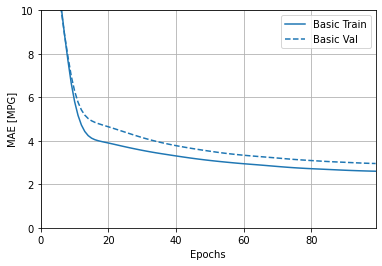

In [16]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MAE')

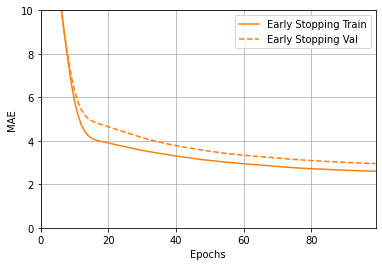

In [17]:
plotter.plot({'Early Stopping': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE')

In [18]:
loss, mae, mse = model.evaluate(X_test, y_test, verbose=2)

5/5 - 0s - loss: 16.4790 - mae: 2.6980 - mse: 16.4790


In [19]:
print("Testing set Mean Abs Error: {:5.2f}".format(mae))

Testing set Mean Abs Error:  2.70


In [20]:
test_predictions = model.predict(X_test).flatten()

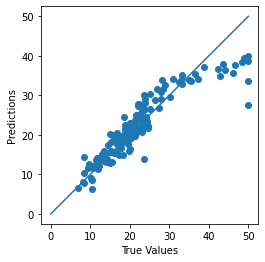

In [22]:
a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
_ = plt.plot([0,50], [0,50])

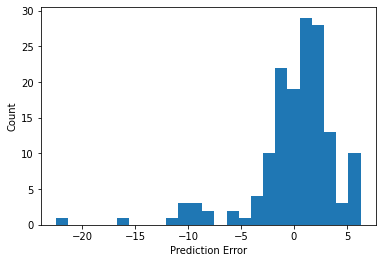

In [23]:
error = test_predictions - y_test.flatten()
plt.hist(error, bins=25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

In [24]:
mean_squared_error(test_predictions, y_test.flatten())

16.479001269305037

## PyTorch

In [25]:
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
from torch.optim import lr_scheduler
from torch.nn.modules.loss import _Loss
from torch.utils.data import DataLoader

In [26]:
class PyTorchTrainer(object):
    def __init__(self,
                 model,
                 optim: Optimizer,
                 criterion: _Loss):
        self.model = model
        self.optim = optim
        self.loss = criterion
        self._check_optim_net_aligned()

    def _check_optim_net_aligned(self):
        assert self.optim.param_groups[0]['params']\
            == list(self.model.parameters())

    def _generate_batches(self,
                          X: Tensor,
                          y: Tensor,
                          size: int = 32) -> Tuple[Tensor]:

        N = X.shape[0]

        for ii in range(0, N, size):
            X_batch, y_batch = X[ii:ii+size], y[ii:ii+size]

            yield X_batch, y_batch

    def _permute_data(self, X: Tensor, y: Tensor, seed=1) -> Tuple[Tensor]:
        perm = torch.randperm(X.shape[0])
        return X[perm], y[perm]

    def fit(self, X_train: Tensor = None,
            y_train: Tensor = None,
            X_test: Tensor = None,
            y_test: Tensor = None,
            train_dataloader: DataLoader = None,
            test_dataloader: DataLoader = None,
            epochs: int=100,
            eval_every: int=10,
            batch_size: int=32,
            final_lr_exp: int = None):

        init_lr = self.optim.param_groups[0]['lr']
        if final_lr_exp:
            decay = (final_lr_exp / init_lr) ** (1.0 / (epochs + 1))
            scheduler = lr_scheduler.ExponentialLR(self.optim, gamma=decay)
        for e in range(epochs):

            if final_lr_exp:
                scheduler.step()

            if not train_dataloader:
                X_train, y_train = self._permute_data(X_train, y_train)

                batch_generator = self._generate_batches(X_train, y_train,
                                                         batch_size)

                self.model.train()

                for ii, (X_batch, y_batch) in enumerate(batch_generator):

                    self.optim.zero_grad()   # zero the gradient buffers

                    output = self.model(X_batch)[0]

                    loss = self.loss(output, y_batch)
                    loss.backward()
                    self.optim.step()

                if e % eval_every == 0:
                    with torch.no_grad():
                        self.model.eval()
                        output = self.model(X_test)[0]
                        loss = self.loss(output, y_test)
                        print("The loss after", e+1, "epochs was", loss.item())

            else:
                for X_batch, y_batch in train_dataloader:

                    self.optim.zero_grad()

                    output = self.model(X_batch)[0]

                    loss = self.loss(output, y_batch)
                    loss.backward()
                    self.optim.step()

                if e % eval_every == 0:
                    with torch.no_grad():
                        self.model.eval()
                        losses = []
                        for X_batch, y_batch in test_dataloader:
                            output = self.model(X_batch)[0]
                            loss = self.loss(output, y_batch)
                            losses.append(loss.item())
                        print("The loss after", e, "epochs was",
                              round(torch.Tensor(losses).mean().item(), 4))

In [27]:
class PyTorchLayer(nn.Module):

    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: Tensor,
                inference: bool = False) -> Tensor:
        raise NotImplementedError()
        
        
class PyTorchModel(nn.Module):

    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: Tensor) -> Tuple[Tensor]:
        raise NotImplementedError()
        
        
def assert_dim(t: Tensor,
               dim: Tensor):
    assert len(t.shape) == dim, \
        '''
        Tensor expected to have dimension {0}, instead has dimension {1}
        '''.format(dim, len(t.shape))
    return None

In [28]:
def inference_mode(m: nn.Module):
    m.eval()
        
        
class DenseLayer(PyTorchLayer):
    def __init__(self,
                 input_size: int,
                 neurons: int,
                 dropout: float = 1.0,
                 activation: nn.Module = None) -> None:

        super().__init__()
        self.linear = nn.Linear(input_size, neurons)
        self.activation = activation
        if dropout < 1.0:
            self.dropout = nn.Dropout(1 - dropout)

    def forward(self, x: Tensor,
                inference: bool = False) -> Tensor:
        if inference:
            self.apply(inference_mode)

        x = self.linear(x)  # does weight multiplication + bias
        if self.activation:
            x = self.activation(x)
        if hasattr(self, "dropout"):
            x = self.dropout(x)

        return x

In [29]:
class BostonModel(PyTorchModel):

    def __init__(self,
                 hidden_size: int = 13,
                 hidden_dropout: float = 1.0):
        super().__init__()
        self.dense1 = DenseLayer(13, hidden_size, 
                                 activation=nn.Tanh(),
                                 dropout = hidden_dropout)
        self.dense2 = DenseLayer(hidden_size, 1)

    def forward(self, x: Tensor,
                inference: bool = False) -> Tensor:
        
        assert_dim(x, 2)
        
        assert x.shape[1] == 13

        x = self.dense1(x, inference)
        return self.dense2(x, inference),

In [30]:
X_train, X_test, y_train, y_test = Tensor(X_train), Tensor(X_test), Tensor(y_train), Tensor(y_test)

In [31]:
pytorch_boston_model = BostonModel(hidden_size=13, hidden_dropout=0.8)
optimizer = torch.optim.SGD(pytorch_boston_model.parameters(), lr=0.001, momentum=0.9)

criterion = nn.MSELoss()

In [32]:
trainer = PyTorchTrainer(pytorch_boston_model, optimizer, criterion)

trainer.fit(X_train=X_train, 
            y_train=y_train, 
            X_test=X_test, 
            y_test=y_test,
            epochs=100,
            eval_every=10,
            final_lr_exp = 0.001)

/Users/steffen/miniconda3/envs/deep_learning/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:118: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


The loss after 1 epochs was 315.2445373535156
The loss after 11 epochs was 27.203739166259766
The loss after 21 epochs was 27.576007843017578
The loss after 31 epochs was 21.500560760498047
The loss after 41 epochs was 20.0095157623291
The loss after 51 epochs was 18.86594009399414
The loss after 61 epochs was 23.746021270751953
The loss after 71 epochs was 18.558094024658203
The loss after 81 epochs was 17.326810836791992
The loss after 91 epochs was 16.714210510253906


In [33]:
torch.mean(torch.pow(pytorch_boston_model(X_test, inference=True)[0] - y_test, 2)).item()

21.084569931030273

In [42]:
test_pred = pytorch_boston_model(X_test)[0].view(-1)
test_actual = y_test

In [43]:
test_pred = test_pred.detach().numpy()
test_actual = test_actual.detach().numpy()

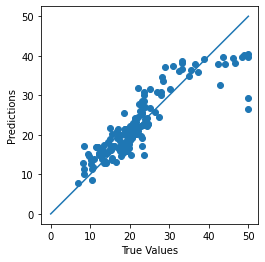

In [44]:
a = plt.axes(aspect='equal')
plt.scatter(test_actual, test_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
_ = plt.plot([0,50], [0,50])

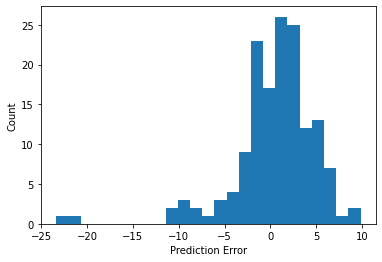

In [48]:
error = test_pred - test_actual.flatten()
plt.hist(error, bins=25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")